<a href="https://colab.research.google.com/github/nwang2208/Bioinformatics-Class-Projects/blob/pseudoalignment/PseudoalignmentProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import packages

In [ ]:
import sys, re
import gzip
import io
import pandas as pd
import collections
import matplotlib.pyplot as plt

Preparing transcriptome fasta file

In [ ]:
chr11=open('/content/drive/MyDrive/pseudoalignment data/chr11_transcriptome.fasta','r')
chr11_lines=chr11.readlines()
hre=re.compile('>(\S+)')
#outh = hre.search(chr11_lines[0])
#if outh:
    #print(outh.group(1))

lre=re.compile('^(\S+)$')
#outl = lre.search(lines[1])
#if outl:
    #print(outl.group(1))

gene={}

for line in chr11_lines:
        outh = hre.search(line)
        if outh:
                id=outh.group(1)
        else:
                outl=lre.search(line)
                if(id in gene.keys()):
                        gene[id] += outl.group(1)
                else:
                        gene[id]  =outl.group(1)


In [ ]:
gene

Iterating through transcriptome and creating hash table of transcriptome (named transcript)

In [ ]:

kmer = 31
start = 0
end = 0
i=0
transcript={}
for key, value in gene.items():
  while(end < len(value)) :
    end = start + kmer
    if(end > len(value)):
      end = len(value)
    seq = value[start:start+kmer]
    if seq in transcript.keys():
      transcript[seq].append(key)
    else:
      #transcript[seq] = [i]
      #i+=1
      transcript[seq] = [key]
    start += 1
  start = 0
  end = 0


In [ ]:
transcript

Prepare reads file into dict called reads2



In [ ]:
r = gzip.open('/content/drive/MyDrive/pseudoalignment data/reads.fasta.gz', 'rb')
reads_lines = r.readlines()

#get rid of the 'b'
i=0
for line in reads_lines:
  reads_lines[i] = line.decode('UTF-8')
  i+=1

#organize into the read number and sequence as an array
reads = {}
for line in reads_lines:
        outh = hre.search(line)
        if outh:
                id=outh.group(1)
        else:
                outl=lre.search(line)
                if(id in reads.keys()):
                        reads[id] += outl.group(1)
                else:
                        reads[id]  =outl.group(1)


In [ ]:
reads

In [ ]:
reads2 = {} #read number | entire sequence

for key, value in reads.items():
  newk = key.split('/')[0]
  reads2[newk] = value

In [ ]:
reads2

Match reads to get equivalence class for forward strand

In [ ]:
#intersection algorithm
start = 0
end = 0
kmer = 31

i_align = {} #read number | eqv class

for key, value in reads2.items():


  classes = [] #hold all the different eqv classes
  while(end < len(value)) :
    end = start + kmer
    if(end > len(value)):
      end = len(value)

    seq = value[start:end]

    if(seq in transcript.keys()): #match in transcriptome, and already eqv classes in align
      classes.append(transcript[seq])
    else: #there was an error
      classes = []
      i_align[key] = {'NA'}
      break

    start += 1

  y = []

  if(len(classes) > 0):
    y = set.intersection(*map(set,classes))
    i_align[key] = y


  start = 0
  end = 0

In [ ]:
#check to make sure no messed up values
num = 0
for key, value in i_align.items():
  if(value == set()):
      num += 1

num


0

In [ ]:
i_align

In [ ]:
#checking number of NA values
i_sum = 0
for key, value in i_align.items():
  if (value == {'NA'}):
    i_sum += 1

In [ ]:
i_sum #intersection

743829

Appying Error Algorithm to align for forward strand

In [ ]:
#functions for intersection

def find_sublist(sub, bigger):
    if not bigger:
        return -1
    if not sub:
        return 0
    first, rest = sub[0], sub[1:]
    pos = 0
    try:
        while True:
            pos = bigger.index(first, pos) + 1
            if not rest or bigger[pos:pos+len(rest)] == rest:
                return pos
    except ValueError:
        return -1

def is_sublist(sub, bigger):
    return find_sublist(sub, bigger) >= 0

def listel (st): #turn a set of tuples to a list of lists
  out = []
  for el in st:
      out.append(list(el))
  return(out)

In [ ]:
#intersection instead

start = 0
end = 0
kmer = 31

bad_pre = [('NA')]
bad = bad_pre*(kmer + 1) #32 NA's


for key, value in i_align.items():
  classes = []
  if(value == {'NA'}):
      while(end < len(reads2[key])) :
          end = start + kmer
          if(end > len(reads2[key])):
              end = len(reads2[key])

          seq = reads2[key][start:end]

          if(seq in transcript.keys()): #match in transcriptome
              if(len(transcript[seq]) == 1): #tuple of one element
                  classes.append(tuple(transcript[seq],))
              else: #tuple of multiple elements
                classes.append(tuple(transcript[seq]))
          else: #there was an error
              classes.append(('NA',))

          start += 1




      y = []
      if(is_sublist(bad,classes)): #list of 32 NA's next to each other
        classes = []
      if(classes != []): #did not find contiguous
          classes2 = set(classes)
          classes2.remove(('NA',))
          classes2 = listel(classes2)
          classes2 = list(classes2)
          if(classes2 == []):
              i_align[key] = {'NA'}
          else:
              y = set.intersection(*map(set, list(classes2)))
              #if(y == set()):
                  #i_align[key] = list(classes2)
              #else:
              i_align[key] = y
      else:
          i_align[key] = {'NA'}


  start = 0
  end = 0


In [ ]:
i_align

In [ ]:
#check to make sure no messed up values
num = 0
for key, value in i_align.items():
  if(value == set()):
      num += 1

num

0

In [ ]:
#checking number of NA's
i_sum = 0
for key, value in i_align.items():
  if (value == {'NA'}):
    i_sum += 1

In [ ]:
i_sum #intersection

606087

Make Reverse Strand Transcriptome into r_transcript

In [ ]:
r_gene = {}

for key,value in gene.items():
  r_seq = ""
  for x in range(0,len(value)):
    base = ''
    if(value[x] == "A"):
      base = 'T'
    elif(value[x] == "T"):
      base = 'A'
    elif(value[x] == "C"):
      base = 'G'
    else:
      base = 'C'
    r_seq += base
  r_gene[key] = r_seq[::-1]


In [ ]:
kmer = 31
start = 0
end = 0
i=0
r_transcript={}
for key, value in r_gene.items():
  while(end < len(value)) :
    end = start + kmer
    if(end > len(value)):
      end = len(value)
    seq = value[start:start+kmer]
    if seq in r_transcript.keys():
      r_transcript[seq].append(key)
    else:
      r_transcript[seq] = [key]
    start += 1
  start = 0
  end = 0



 Match reads with reverse transcriptome

In [ ]:
#intersection

start = 0
end = 0
kmer = 31

i_r_align = {} #read number | eqv class

for key, value in reads2.items():


  classes = [] #hold all the different eqv classes
  while(end < len(value)) :
    end = start + kmer
    if(end > len(value)):
      end = len(value)

    seq = value[start:end]

    if(seq in r_transcript.keys()): #match in transcriptome, and already eqv classes in align
      classes.append(r_transcript[seq])
    else: #there was an error
      classes = []
      i_r_align[key] = {'NA'}
      break

    start += 1

  y = []

  if(len(classes) > 0):
    y = set.intersection(*map(set,classes))
    i_r_align[key] = y


  start = 0
  end = 0

In [ ]:
#check to make sure no messed up values
num = 0
for key, value in i_r_align.items():
  if(value == set()):
      num += 1

num

0

In [ ]:
#checking number of NA's
i_sum = 0
for key, value in i_r_align.items():
  if (value == {'NA'}):
    i_sum += 1

In [ ]:
i_sum #intersection

748577

Apply Error Algorithm to r_align

In [ ]:
#functions for intersection

def find_sublist(sub, bigger):
    if not bigger:
        return -1
    if not sub:
        return 0
    first, rest = sub[0], sub[1:]
    pos = 0
    try:
        while True:
            pos = bigger.index(first, pos) + 1
            if not rest or bigger[pos:pos+len(rest)] == rest:
                return pos
    except ValueError:
        return -1

def is_sublist(sub, bigger):
    return find_sublist(sub, bigger) >= 0

def listel (st): #turn a set of tuples to a list of lists
  out = []
  for el in st:
      out.append(list(el))
  return(out)

In [ ]:
#intersection instead

start = 0
end = 0
kmer = 31

bad_pre = [('NA')]
bad = bad_pre*(kmer + 1)


for key, value in i_r_align.items():
  classes = []
  if(value == {'NA'}):
      while(end < len(reads2[key])) :
          end = start + kmer
          if(end > len(reads2[key])):
              end = len(reads2[key])

          seq = reads2[key][start:end]

          if(seq in r_transcript.keys()): #match in transcriptome
              if(len(r_transcript[seq]) == 1): #tuple of one element
                  classes.append(tuple(r_transcript[seq],))
              else: #tuple of multiple elements
                classes.append(tuple(r_transcript[seq]))
          else: #there was an error
              classes.append(('NA',))

          start += 1




      y = []
      if(is_sublist(bad,classes)): #list of 32 NA's next to each other
        classes = []
      if(classes != []): #did not find contiguous
          classes2 = set(classes)
          classes2.remove(('NA',))
          classes2 = listel(classes2)
          classes2 = list(classes2)
          if(classes2 == []):
              i_r_align[key] = {'NA'}
          else:
              y = set.intersection(*map(set, list(classes2)))
              #if(y == set()):
                  #i_align[key] = list(classes2)
              #else:
              i_r_align[key] = y
      else:
          i_r_align[key] = {'NA'}


  start = 0
  end = 0


In [ ]:
#check to make sure no messed up values
num = 0
for key, value in i_r_align.items():
  if(value == set()):
      num += 1

num

0

In [ ]:
i_r_align

In [ ]:
#checking number of NA's
i_sum = 0
for key, value in i_r_align.items():
  if (value == {'NA'}):
    i_sum += 1

In [ ]:
i_sum #intersection error

609621

Make sure each read only has 1 eqv class ($)

In [ ]:
#function to find the union of the forward and reverse strand eqv classes
def Union(lst1, lst2):
    final_list = set(set(lst1) | set(lst2))
    return tuple(final_list)

In [ ]:
def convert(list):
    return tuple(sorted(tuple(i for i in list))) #make sure order of all tuples would be the same if same eqv class

In [ ]:
for key, value in i_r_align.items():
  i_r_align[key] = convert(value)

In [ ]:
for key, value in i_align.items():
  i_align[key] = convert(value)

In [ ]:
i_align

In [ ]:
i_r_align

In [ ]:
#intersection

i_combine_align = {}

for key, value in i_align.items():
  if((i_align[key] != ('NA',)) & (i_r_align[key] != ('NA',))): #different sets of real eqv classes
      i_combine_align[key] = Union(i_align[key], i_r_align[key])#union of the forward and reverse strands
      #i_combine_align[key] = i_align[key]
  elif((i_align[key] != ('NA',)) & (i_r_align[key] == ('NA',))): #eqv class only in forward strand, reverse strand no match
        i_combine_align[key] = i_align[key]
  elif((i_r_align[key] != ('NA',)) & (i_align[key] == ('NA',))): #eqv class only in reverse strand, forward strand no match
        i_combine_align[key] = i_r_align[key]
  else: #both strands do not match --> NA
        i_combine_align[key] = ('NA',)


In [ ]:
i_combine_align

Make dict of equivalence classes and counts for combined align hashtables

In [ ]:
i_r_align

In [ ]:
i_align

In [ ]:
i_combine_final = {}

for key, value in i_combine_align.items():
  if(value in i_combine_final.keys()): #eqv class already in table
    i_combine_final[value] += 1
  else: #eqv class not in table yet
    i_combine_final[value] = 1

In [ ]:
len(i_combine_final) #number of eqv classes

14133

In [ ]:
#checking the number of reads
sum = 0

for key, value in i_combine_final.items():
  sum += value

In [ ]:
sum #matches with reads2, so i_combine_final has the right amount of reads!

1282526

In [ ]:
len(reads2) #number of reads

1282526

In [ ]:
i_combine_final[('NA',)] #checking number of NA's

7

In [ ]:
i_combine_final

Make the final table

In [ ]:
#turn i_combine_final into a dataframe
pd.DataFrame(i_combine_final.items())
df = pd.DataFrame(i_combine_final.items(), columns=['isoforms in equivalence class', 'counts'])

In [ ]:
df

In [ ]:
#add a column for number of items in equivalence class
class_count = []

for i in range(0,len(df)):
    if(df.iloc[i,0] == ('NA',)):
        class_count.append(0)
    else:
        class_count.append(len(df.iloc[i,0]))

df['number of items in equivalence class'] = class_count

In [ ]:
df

,isoforms in equivalence class,counts,number of items in equivalence class
0,"(ENST00000410108, ENST00000332865, ENST0000048...",52,5
1,"(ENST00000410108,)",90,1
2,"(ENST00000410108, ENST00000529614, ENST0000033...",17,5
3,"(ENST00000410108, ENST00000486280, ENST0000033...",2,5
4,"(ENST00000410108, ENST00000332865, ENST0000038...",1,4
...,...,...,...
14128,"(ENST00000455971,)",1,1
14129,"(ENST00000339772, ENST00000535456)",12,2
14130,"(ENST00000431683, ENST00000389887, ENST0000033...",1,4
14131,"(ENST00000524765,)",9,1


In [ ]:
#rearrange columns to look like the example in the project description
df2 = df.iloc[:,[1,2,0]]
df2

,counts,number of items in equivalence class,isoforms in equivalence class
0,52,5,"(ENST00000410108, ENST00000332865, ENST0000048..."
1,90,1,"(ENST00000410108,)"
2,17,5,"(ENST00000410108, ENST00000529614, ENST0000033..."
3,2,5,"(ENST00000410108, ENST00000486280, ENST0000033..."
4,1,4,"(ENST00000410108, ENST00000332865, ENST0000038..."
...,...,...,...
14128,1,1,"(ENST00000455971,)"
14129,12,2,"(ENST00000339772, ENST00000535456)"
14130,1,4,"(ENST00000431683, ENST00000389887, ENST0000033..."
14131,9,1,"(ENST00000524765,)"


In [ ]:
df2.to_csv('pseudoalingment.csv', index=False) #save csv

In [ ]:
#make dict with total counts for each size eqv class
graph = {} #number of items in equivalence class | counts
for i in range(0, len(df2)):
    if(df2.iloc[i,1] in graph.keys()): #number of items already in dict
        graph[df2.iloc[i,1]] += df2.iloc[i,0]
    else:
        graph[df2.iloc[i,1]] = df2.iloc[i,0]
graph

In [ ]:
#turn that dict into a data frame
pd.DataFrame(graph.items())
plot = pd.DataFrame(graph.items(), columns=['number of items in equivalence class', 'counts'])

plot

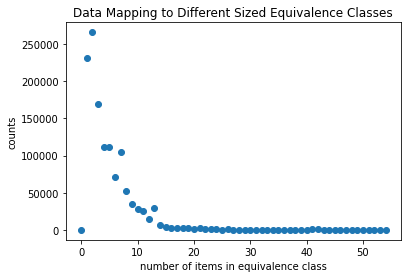

In [ ]:
#graph the dataframe
plt.scatter(plot['number of items in equivalence class'], plot['counts'])
plt.title("Data Mapping to Different Sized Equivalence Classes")
plt.xlabel("number of items in equivalence class")
plt.ylabel("counts")
plt.show()


The above figure shows the amount of reads that map to certain sized equivalence classes. As one can see, there appears to be a relationship that looks like an exponential regression in the figure. As the number of isoforms in the equivalence class increases, less reads map to that particular equivalence class.